In [15]:
# The goal of this script is to use bert to get a sentence embedding for each overview.

import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
import os
from torch.utils.data import DataLoader
import csv
from tqdm import tqdm

from data_prep import load_movies_full_df
from features import get_director_from_crew, parse_into_python_objects

MIN_VOTES_PER_MOVIE = 50
NEUTRAL_RATING = 2.5
MIN_POSITIVE_VOTES_PER_USER = 20
DESIRED_COLUMNS = ['id', 'crew', 'overview']
PATH_TO_SENTENCE_EMBEDDINGS = 'sentence_embeddings_director_-1.csv'

In [4]:
movies_df = load_movies_full_df(
        movies_metadata_path='data/IMDB_Ratings/movies_metadata.csv',
        credits_path='data/IMDB_Ratings/credits.csv',
        n_votes=MIN_VOTES_PER_MOVIE,
        desired_columns=DESIRED_COLUMNS)


c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(movies_metadata_path)
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enough_votes['overview'] = enough_votes['overview'].fillna('')


In [9]:
movies_df.shape

(9171, 3)

In [10]:
movies_df.drop(movies_df[movies_df['overview'] == ""].index, inplace=True)
movies_df.shape


(9135, 3)

In [17]:
movies_df = parse_into_python_objects(movies_df, ['crew'])
movies_df['director'] = get_director_from_crew(movies_df['crew'])
print(movies_df.shape)
movies_df.head()

Getting director names ...
(9135, 4)


,id,crew,overview,director
0,862,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","Led by Woody, Andy's toys live happily in his ...",John Lasseter
1,8844,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",When siblings Judy and Peter discover an encha...,Joe Johnston
2,15602,"[{'credit_id': '52fe466a9251416c75077a89', 'de...",A family wedding reignites the ancient feud be...,Howard Deutch
3,11862,"[{'credit_id': '52fe44959251416c75039ed7', 'de...",Just when George Banks has recovered from his ...,Charles Shyer
4,949,"[{'credit_id': '52fe4292c3a36847f802916d', 'de...","Obsessive master thief, Neil McCauley leads a ...",Michael Mann


In [18]:
movies_df.drop(columns=['crew'], inplace=True)
movies_df.head()

,id,overview,director
0,862,"Led by Woody, Andy's toys live happily in his ...",John Lasseter
1,8844,When siblings Judy and Peter discover an encha...,Joe Johnston
2,15602,A family wedding reignites the ancient feud be...,Howard Deutch
3,11862,Just when George Banks has recovered from his ...,Charles Shyer
4,949,"Obsessive master thief, Neil McCauley leads a ...",Michael Mann


In [21]:
movies_df['director'].nunique()

3779

In [30]:
director_count_df = movies_df.groupby(['director'])['director'].count().reset_index(name='moviesDirected')
director_count_df.describe()

,moviesDirected
count,3779.000000
mean,2.414395
std,2.747204
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,45.000000


<AxesSubplot:>

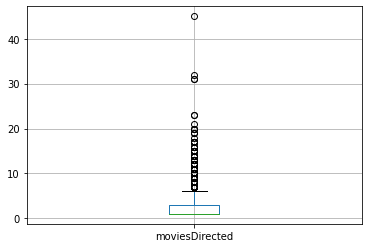

In [31]:
director_count_df.boxplot(column='moviesDirected')

## Conclusion

There are not enough instances for each director to make a classification problem where director is the label.